# Assignment 2

In this assigment, we will work with the *Adult* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/2/adult). Extract the data files into the subdirectory: `../05_src/data/adult/` (relative to `./05_src/`).

# Load the data

Assuming that the files `adult.data` and `adult.test` are in `../05_src/data/adult/`, then you can use the code below to load them.

In [14]:
import pandas as pd
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
    'native-country', 'income'
]
adult_dt = (pd.read_csv(r'C:\Users\Aksha\Music\DSI\Repos\production\05_src\data\adult\adult.csv', header=None, names=columns)
              .assign(income=lambda x: (x.income.str.strip() == '>50K')*1))


# Get X and Y

Create the features data frame and target data:

+ Create a dataframe `X` that holds the features (all columns that are not `income`).
+ Create a dataframe `Y` that holds the target data (`income`).
+ From `X` and `Y`, obtain the training and testing data sets:

    - Use a train-test split of 70-30%. 
    - Set the random state of the splitting function to 42.

In [15]:
from sklearn.model_selection import train_test_split

# Create the features dataframe X (all columns except 'income')
X = adult_dt.drop(columns=['income'])

# Create the target dataframe Y (only the 'income' column)
Y = adult_dt['income']

# Split the data into training and testing sets with a 70-30% split and random state of 42
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

## Random States

Please comment: 

+ What is the [random state](https://scikit-learn.org/stable/glossary.html#term-random_state) of the [splitting function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)? 
+ Why is it [useful](https://en.wikipedia.org/wiki/Reproducibility)?


 * The `random_state` parameter in the splitting function is used to control the randomness of the data shuffling process.
 * 
 * Setting a `random_state` ensures that the data is split in the same way every time the code is run, which is crucial for reproducibility.
 * 
 * Reproducibility is important because it allows others to replicate the results of an experiment or analysis, ensuring that findings are consistent and reliable.


# Preprocessing

Create a [Column Transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) that treats the features as follows:

- Numerical variables

    * Apply [KNN-based imputation for completing missing values](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html):
        
        + Consider the 7 nearest neighbours.
        + Weight each neighbour by the inverse of its distance, causing closer neigbours to have more influence than more distant ones.
    * [Scale features using statistics that are robust to outliers](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler).

- Categorical variables: 
    
    * Apply a [simple imputation strategy](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer):

        + Use the most frequent value to complete missing values, also called the *mode*.

    * Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):
        
        + Handle unknown labels if they exist.
        + Drop one column for binary variables.
    
    
The column transformer should look like this:

![](./images/assignment_2__column_transformer.png)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Define the numerical and categorical columns
numerical_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

# Define the transformers for numerical and categorical columns
num_transformations = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=7, weights='distance')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])

# Create the column transformer
ColumnTransformer(
    transformers=[
        ('num_transforms', num_transformations, numerical_cols),
        ('cat_transforms', categorical_transformer, categorical_cols)
    ]
)
model_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor)
])
# Display the pipeline
model_pipeline

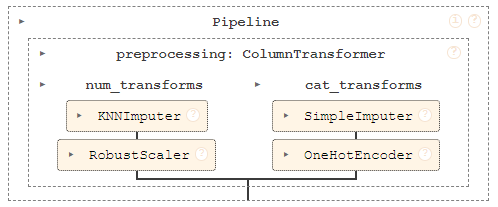

## Model Pipeline

Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `classifier` and assign a [`RandomForestClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to it.

The pipeline looks like this:

![](./images/assignment_2__pipeline.png)

In [ ]:
# Add the classifier to the pipeline
model_pipeline.steps.append(('classifier', RandomForestClassifier()))

# Display the updated pipeline
model_pipeline

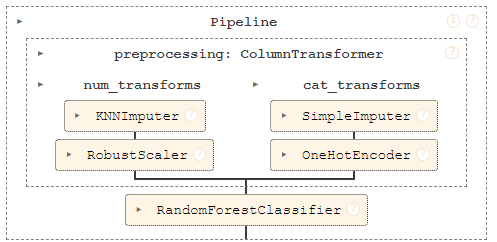

# Cross-Validation

Evaluate the model pipeline using [`cross_validate()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html):

+ Measure the following [preformance metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values): negative log loss, ROC AUC, accuracy, and balanced accuracy.
+ Report the training and validation results. 
+ Use five folds.


In [44]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, log_loss, roc_auc_score, accuracy_score, balanced_accuracy_score
import pandas as pd

# Define the scoring metrics
scoring = {
    'neg_log_loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True),
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'balanced_accuracy': 'balanced_accuracy'
}

# Perform cross-validation
cv_results = cross_validate(model_pipeline, X_train, Y_train, cv=5, scoring=scoring, return_train_score=True)

# Display the results
cv_results


c:\Users\Aksha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
c:\Users\Aksha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Aksha\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


{'fit_time': array([12.76925325, 11.41404676, 11.55551004, 11.48241687, 11.78534937]),
 'score_time': array([0.35805273, 0.23131919, 0.25320625, 0.25249887, 0.23177671]),
 'test_neg_log_loss': array([-0.34103205, -0.34759801, -0.3911054 , -0.38333291, -0.40709718]),
 'train_neg_log_loss': array([-0.08152107, -0.08178008, -0.08160201, -0.08168248, -0.08161147]),
 'test_roc_auc': array([0.90616816, 0.90222644, 0.90043794, 0.90688417, 0.90260446]),
 'train_roc_auc': array([1., 1., 1., 1., 1.]),
 'test_accuracy': array([0.85084448, 0.8471156 , 0.84993418, 0.85849057, 0.8569548 ]),
 'train_accuracy': array([1.        , 1.        , 0.99994516, 0.99994516, 1.        ]),
 'test_balanced_accuracy': array([0.77462911, 0.7663292 , 0.77111175, 0.78106663, 0.77666846]),
 'train_balanced_accuracy': array([1.        , 1.        , 0.99988693, 0.99988693, 1.        ])}

Display the fold-level results as a pandas data frame and sorted by negative log loss of the test (validation) set.

In [45]:
# Sort the cross-validation results by the negative log loss of the test set
sorted_cv_results_df = cv_results_df.sort_values(by='test_neg_log_loss')

# Display the sorted DataFrame
sorted_cv_results_df

,fit_time,score_time,test_neg_log_loss,train_neg_log_loss,test_roc_auc,train_roc_auc,test_accuracy,train_accuracy,test_balanced_accuracy,train_balanced_accuracy
2,13.285856,0.281487,-0.383781,-0.081655,0.900983,1.0,0.851689,1.000000,0.772578,1.000000
1,12.399276,0.320035,-0.379535,-0.081446,0.903046,1.0,0.848212,1.000000,0.769511,1.000000
3,13.380451,0.270796,-0.373000,-0.082061,0.905892,1.0,0.860026,0.999945,0.784234,0.999887
4,15.528301,0.437833,-0.372823,-0.081401,0.902750,1.0,0.856516,1.000000,0.776379,1.000000
0,13.379602,0.290936,-0.348854,-0.081627,0.905381,1.0,0.849090,1.000000,0.771934,1.000000


Calculate the mean of each metric. 

In [47]:
# Calculate the mean of each metric
mean_metrics = {metric: cv_results_df[metric].mean() for metric in cv_results_df.columns}

# Display the mean metrics
mean_metrics
# Convert the mean metrics dictionary to a DataFrame
mean_metrics_df = pd.DataFrame(mean_metrics, index=[0])

# Display the DataFrame
mean_metrics_df

,fit_time,score_time,test_neg_log_loss,train_neg_log_loss,test_roc_auc,train_roc_auc,test_accuracy,train_accuracy,test_balanced_accuracy,train_balanced_accuracy
0,13.594697,0.320217,-0.371599,-0.081638,0.90361,1.0,0.853107,0.999989,0.774927,0.999977


Calculate the same performance metrics (negative log loss, ROC AUC, accuracy, and balanced accuracy) using the testing data `X_test` and `Y_test`. Display results as a dictionary.

*Tip*: both, `roc_auc()` and `neg_log_loss()` will require prediction scores from `pipe.predict_proba()`. However, for `roc_auc()` you should only pass the last column `Y_pred_proba[:, 1]`. Use `Y_pred_proba` with `neg_log_loss()`.

In [50]:
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, balanced_accuracy_score

# Fit the model pipeline with the training data
model_pipeline.fit(X_train, Y_train)

# Get prediction probabilities
Y_pred_proba = model_pipeline.predict_proba(X_test)

# Calculate the performance metrics
test_metrics = {
    'neg_log_loss': -log_loss(Y_test, Y_pred_proba),
    'roc_auc': roc_auc_score(Y_test, Y_pred_proba[:, 1]),
    'accuracy': accuracy_score(Y_test, model_pipeline.predict(X_test)),
    'balanced_accuracy': balanced_accuracy_score(Y_test, model_pipeline.predict(X_test))
}

# Display the results
test_metrics

{'neg_log_loss': -0.3892373100546432,
 'roc_auc': 0.9008978097916222,
 'accuracy': 0.8554611526256526,
 'balanced_accuracy': 0.7750663589720402}

# Target Recoding

In the first code chunk of this document, we loaded the data and immediately recoded the target variable `income`. Why is this [convenient](https://scikit-learn.org/stable/modules/model_evaluation.html#binary-case)?

The specific line was:

```
adult_dt = (pd.read_csv('../05_src/data/adult/adult.data', header = None, names = columns)
              .assign(income = lambda x: (x.income.str.strip() == '>50K')*1))
```


Recoding the target variable income to binary (0 or 1) simplifies model evaluation and interpretation, especially for binary classification tasks. It allows the use of metrics like accuracy, precision, and recall directly. This preprocessing step ensures consistency and efficiency in subsequent analysis.

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Becker,Barry and Kohavi,Ronny. (1996). Adult. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20.